## Fit AuotoARIMA

In [1]:
import pandas as pd


# Load the dataset
file_path = 'MS_68185_POD_91_Memory.csv'
data = pd.read_csv(file_path, parse_dates=True)

# Convert the timestamp to the desired format
# Start date is 01/01/2022
start_date = pd.Timestamp('2022-01-01')

# Convert the timestamp from milliseconds to seconds and add it to the start date
data['timestamp'] = data['timestamp'].apply(lambda x: start_date + pd.Timedelta(seconds=x/1000))


# Creating the two univariate datasets with the corrected timestamp
memory_usage_dataset_with_corrected_timestamp = data[['timestamp', 'memory_utilization']].copy()
memory_usage_dataset_with_corrected_timestamp  = memory_usage_dataset_with_corrected_timestamp.rename(columns={'memory_utilization': 'y', 'timestamp': 'ds'})

#Resample to hours
memory_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(memory_usage_dataset_with_corrected_timestamp['ds'])
memory_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.resample('H').mean()
memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.fillna(0)

memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.reset_index()


memory_usage_dataset_with_corrected_timestamp['unique_id'] = 'MS_68185_POD_91_Memory'

memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.head(7*24) #Select last 7 days of data to make example faster

# Displaying the first few rows of each corrected dataset to verify
memory_usage_dataset_with_corrected_timestamp




,ds,y,unique_id
0,2022-01-01 00:00:00,0.662094,MS_68185_POD_91_Memory
1,2022-01-01 01:00:00,0.661397,MS_68185_POD_91_Memory
2,2022-01-01 02:00:00,0.661365,MS_68185_POD_91_Memory
3,2022-01-01 03:00:00,0.661424,MS_68185_POD_91_Memory
4,2022-01-01 04:00:00,0.661455,MS_68185_POD_91_Memory
...,...,...,...
163,2022-01-07 19:00:00,0.672355,MS_68185_POD_91_Memory
164,2022-01-07 20:00:00,0.672235,MS_68185_POD_91_Memory
165,2022-01-07 21:00:00,0.672577,MS_68185_POD_91_Memory
166,2022-01-07 22:00:00,0.672825,MS_68185_POD_91_Memory


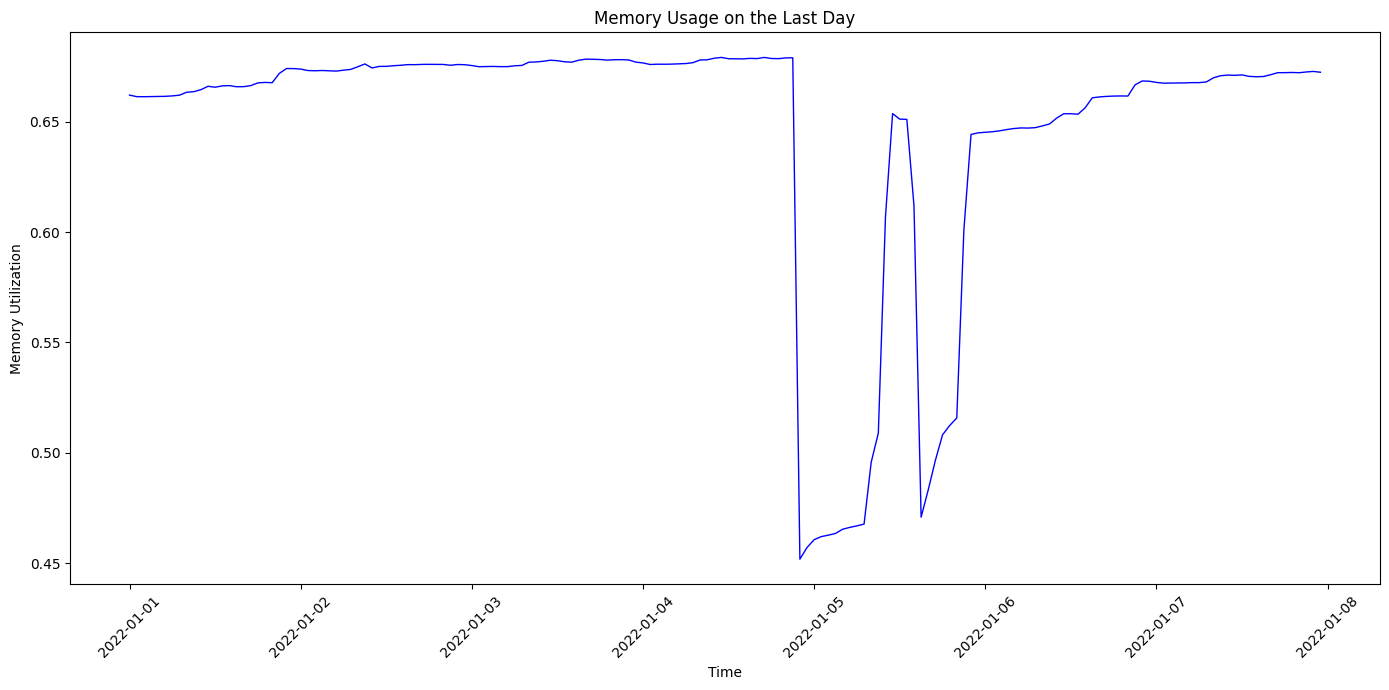

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(memory_usage_dataset_with_corrected_timestamp['ds'], memory_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('Memory Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('Memory Utilization')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    MSTL,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    MSTL(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H',
    fallback_model = SeasonalNaive(season_length=24),
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
#Setting n_windows=1 mirrors a traditional train-test split with our historical data serving as the training set 
#and the last 48 hours serving as the testing set.
crossvaldation_df = sf.cross_validation(
    df=memory_usage_dataset_with_corrected_timestamp,
    h=24,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,,
MS_68185_POD_91_Memory,2022-01-07 00:00:00,2022-01-06 23:00:00,0.667851,0.668346,0.668383,0.668382,0.664299,0.670360,0.645270,0.654581,0.645270,0.668382
MS_68185_POD_91_Memory,2022-01-07 01:00:00,2022-01-06 23:00:00,0.667506,0.668346,0.668383,0.668382,0.665010,0.670528,0.645499,0.654581,0.645499,0.668382
MS_68185_POD_91_Memory,2022-01-07 02:00:00,2022-01-06 23:00:00,0.667543,0.668346,0.668383,0.668382,0.663882,0.670949,0.645903,0.654581,0.645903,0.668382
MS_68185_POD_91_Memory,2022-01-07 03:00:00,2022-01-06 23:00:00,0.667589,0.668346,0.668383,0.668382,0.663258,0.671546,0.646476,0.654581,0.646476,0.668382
MS_68185_POD_91_Memory,2022-01-07 04:00:00,2022-01-06 23:00:00,0.667636,0.668346,0.668383,0.668382,0.662845,0.672318,0.646944,0.654581,0.646944,0.668382
MS_68185_POD_91_Memory,2022-01-07 05:00:00,2022-01-06 23:00:00,0.667749,0.668346,0.668383,0.668382,0.662096,0.672823,0.647221,0.654581,0.647221,0.668382
MS_68185_POD_91_Memory,2022-01-07 06:00:00,2022-01-06 23:00:00,0.667751,0.668346,0.668383,0.668382,0.661393,0.673344,0.647150,0.654581,0.647150,0.668382
MS_68185_POD_91_Memory,2022-01-07 07:00:00,2022-01-06 23:00:00,0.668067,0.668346,0.668383,0.668382,0.660877,0.673933,0.647338,0.654581,0.647338,0.668382
MS_68185_POD_91_Memory,2022-01-07 08:00:00,2022-01-06 23:00:00,0.669940,0.668346,0.668383,0.668382,0.664816,0.681175,0.648137,0.654581,0.648137,0.668382


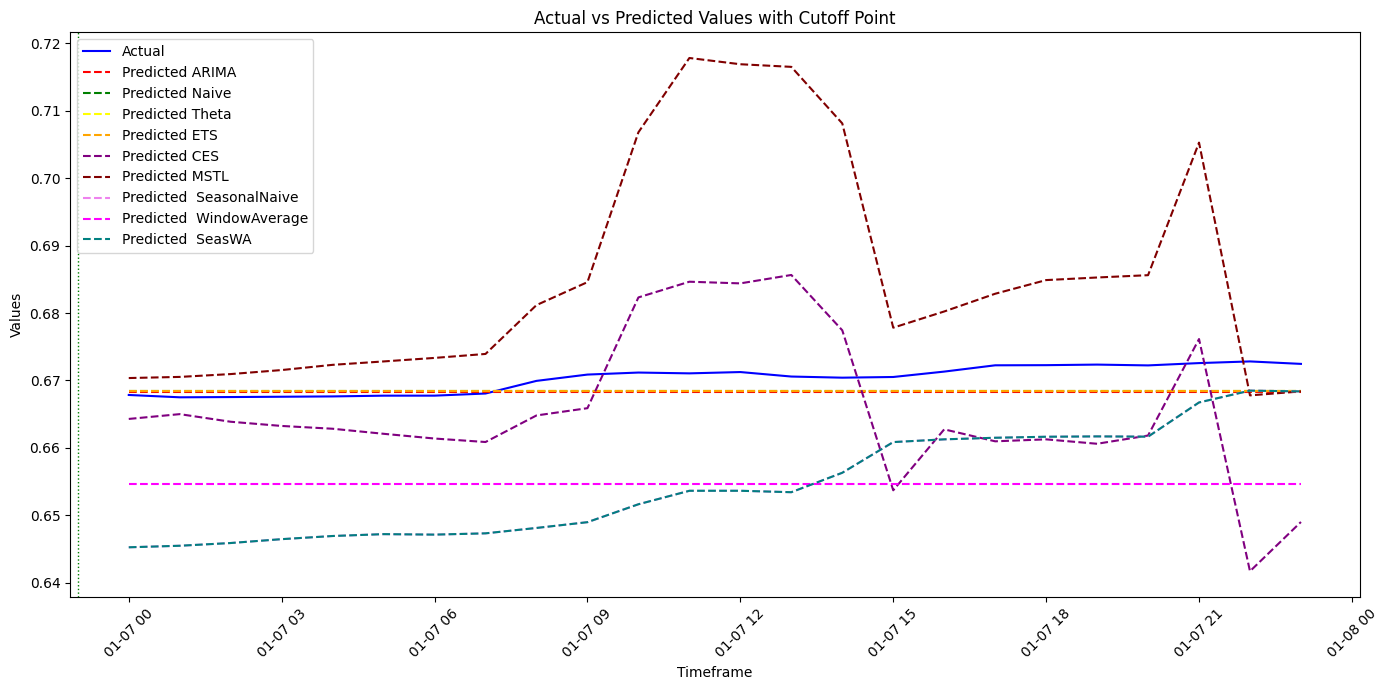

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted MSTL', color='maroon', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(memory_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
df_cv = cross_validation(model, horizon='1 days', initial='5 days')

  0%|          | 0/2 [00:00<?, ?it/s]

17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:56:59 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-06 12:00:00,0.607697,0.538896,0.686832,0.653649,2022-01-06 11:00:00
1,2022-01-06 13:00:00,0.600143,0.521203,0.668616,0.653437,2022-01-06 11:00:00
2,2022-01-06 14:00:00,0.586622,0.515399,0.659055,0.656318,2022-01-06 11:00:00
3,2022-01-06 15:00:00,0.572884,0.497392,0.646653,0.660868,2022-01-06 11:00:00
4,2022-01-06 16:00:00,0.564898,0.492595,0.638236,0.661274,2022-01-06 11:00:00
5,2022-01-06 17:00:00,0.565142,0.493096,0.636718,0.661508,2022-01-06 11:00:00
6,2022-01-06 18:00:00,0.571088,0.500949,0.649619,0.661658,2022-01-06 11:00:00
7,2022-01-06 19:00:00,0.577049,0.506473,0.647396,0.661710,2022-01-06 11:00:00
8,2022-01-06 20:00:00,0.578034,0.503947,0.651357,0.661671,2022-01-06 11:00:00
9,2022-01-06 21:00:00,0.572805,0.498292,0.645158,0.666741,2022-01-06 11:00:00


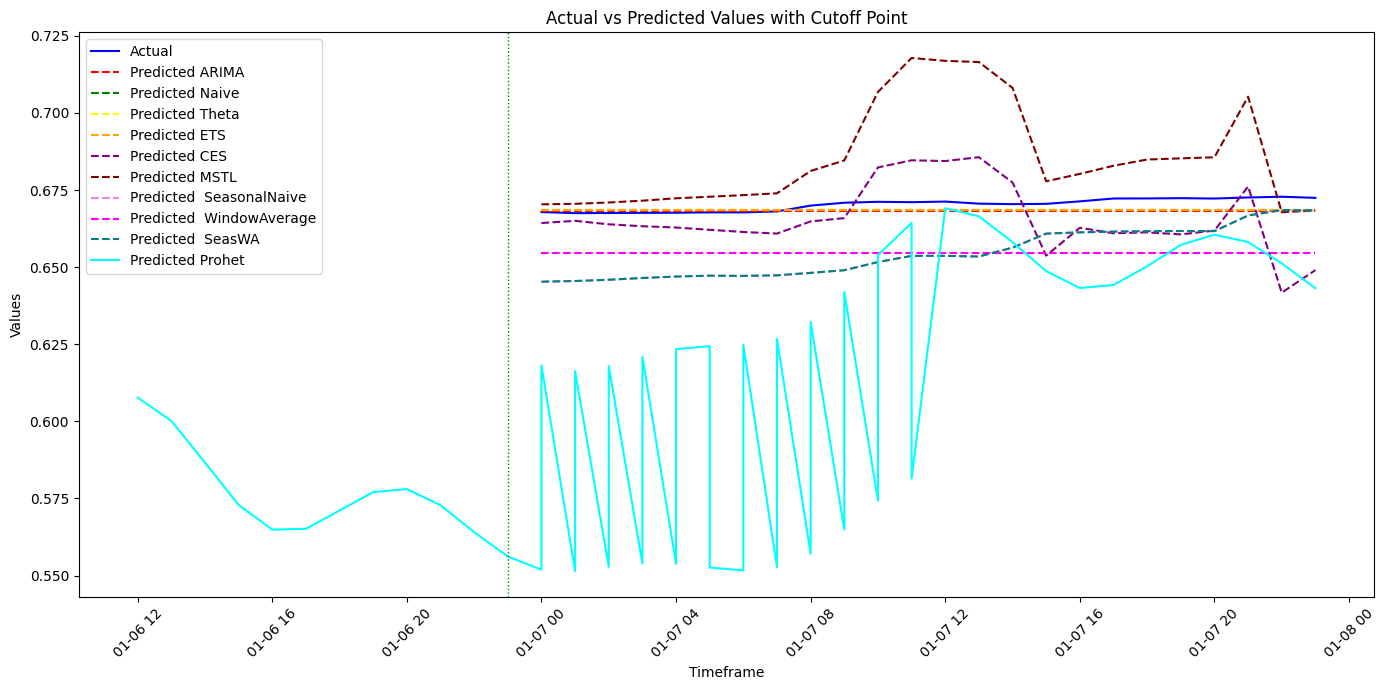

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted MSTL', color='maroon', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,MS_68185_POD_91_Memory,2022-01-07 00:00:00,2022-01-06 23:00:00,0.667851,0.668346,0.668383,0.668382,0.664299,0.670360,0.645270,0.654581,0.645270,0.668382,0.607697
1,MS_68185_POD_91_Memory,2022-01-07 01:00:00,2022-01-06 23:00:00,0.667506,0.668346,0.668383,0.668382,0.665010,0.670528,0.645499,0.654581,0.645499,0.668382,0.600143
2,MS_68185_POD_91_Memory,2022-01-07 02:00:00,2022-01-06 23:00:00,0.667543,0.668346,0.668383,0.668382,0.663882,0.670949,0.645903,0.654581,0.645903,0.668382,0.586622
3,MS_68185_POD_91_Memory,2022-01-07 03:00:00,2022-01-06 23:00:00,0.667589,0.668346,0.668383,0.668382,0.663258,0.671546,0.646476,0.654581,0.646476,0.668382,0.572884
4,MS_68185_POD_91_Memory,2022-01-07 04:00:00,2022-01-06 23:00:00,0.667636,0.668346,0.668383,0.668382,0.662845,0.672318,0.646944,0.654581,0.646944,0.668382,0.564898
5,MS_68185_POD_91_Memory,2022-01-07 05:00:00,2022-01-06 23:00:00,0.667749,0.668346,0.668383,0.668382,0.662096,0.672823,0.647221,0.654581,0.647221,0.668382,0.565142
6,MS_68185_POD_91_Memory,2022-01-07 06:00:00,2022-01-06 23:00:00,0.667751,0.668346,0.668383,0.668382,0.661393,0.673344,0.647150,0.654581,0.647150,0.668382,0.571088
7,MS_68185_POD_91_Memory,2022-01-07 07:00:00,2022-01-06 23:00:00,0.668067,0.668346,0.668383,0.668382,0.660877,0.673933,0.647338,0.654581,0.647338,0.668382,0.577049
8,MS_68185_POD_91_Memory,2022-01-07 08:00:00,2022-01-06 23:00:00,0.669940,0.668346,0.668383,0.668382,0.664816,0.681175,0.648137,0.654581,0.648137,0.668382,0.578034
9,MS_68185_POD_91_Memory,2022-01-07 09:00:00,2022-01-06 23:00:00,0.670875,0.668346,0.668383,0.668382,0.665892,0.684579,0.648994,0.654581,0.648994,0.668382,0.572805


In [14]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [15]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,,
MS_68185_POD_91_Memory,0.000007,0.000007,0.000007,0.000141,0.000475,0.000282,0.000249,0.000282,0.000007,0.010867,AutoTheta
